In [261]:
print("hello")

hello


In [262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

In [263]:
carData_filepath = "C:/Users/PORTATIL/OneDrive/Documentos/Projects/CochecitosScrapping/OutputData/coches_data_compiled_2025-02-22_01-14.parquet"

# Load dataset
df1 = pd.read_parquet(carData_filepath)
print(df1.columns)
df1 = df1.drop(columns=['Scrape Date'])
print(df1.describe())

carData2_filepath = "C:/Users/PORTATIL/OneDrive/Documentos/Projects/CochecitosScrapping/OutputData/coches_data_consolidado_2025-02-19_17-27.parquet"

df2 = pd.read_parquet(carData2_filepath)
print(df2.columns)
print(df2.describe())


df = pd.concat([df1, df2], axis=0, ignore_index=True)
df = df.dropna()


Index(['Title', 'Price', 'Features', 'URL', 'Scrape Date', 'Source File'], dtype='object')
                                      Title     Price Features  \
count                                  1975      1975     1975   
unique                                 1468       828     1933   
top     FIAT 500 Dolcevita 1.0 Hybrid 70 CV  19.990 €            
freq                                     12        19       11   

                                                      URL  \
count                                                1975   
unique                                               1953   
top     https://www.coches.net/seat-ateca-15-tsi-110kw...   
freq                                                    2   

                           Source File  
count                             1975  
unique                               1  
top     car_links_2025-02-21_20-18.txt  
freq                              1975  
Index(['Title', 'Price', 'Features', 'URL', 'Source File'], dtype='

In [264]:
df.describe()

,Title,Price,Features,URL,Source File
count,9129,9129,9129,9129,9129
unique,3673,1435,6960,7147,7
top,TOYOTA Corolla 1.8 125H ACTIVE TECH ECVT,12.990 €,,https://www.coches.net/opel-corsa-1.5d-dt-74kw...,car_links_2025-02-19_01-02.txt
freq,58,189,115,6,2947


In [265]:
# Split features into separate columns
df["FeaturesList"] = df["Features"].str.split(", ")
features_df = df["FeaturesList"].apply(pd.Series)

#concatenate back the desired features
df = pd.concat([df, features_df.iloc[:, [0, 1]]], axis=1)
df = df.rename(columns={1: "KM", 0: "YEAR"})


In [266]:
# Split features into separate columns
df["BrandModel"] = df["Title"].str.split(" ")
features_df = df["BrandModel"].apply(pd.Series)

#concatenate back the desired features
df = pd.concat([df, features_df.iloc[:, [0, 1]]], axis=1)
df = df.rename(columns={1: "Model", 0: "Brand"})

print(df.columns)


Index(['Title', 'Price', 'Features', 'URL', 'Source File', 'FeaturesList',
       'YEAR', 'KM', 'BrandModel', 'Brand', 'Model'],
      dtype='object')


In [267]:
# Clean and convert YEAR column
df["YEAR"] = (
    df["YEAR"]
    .astype(str)  # Ensure it's a string
    .str.strip()  # Remove leading/trailing spaces
    .replace("", np.nan)  # Convert empty strings to NaN
    .dropna()  # Remove NaN values
    .astype(int)  # Convert to integer
)

# Convert price to integer (removing non-digit characters)
df["PriceInt"] = (
    df["Price"].astype(str)
    .str.replace(r"[^\d]", "", regex=True)  # Keep only digits
    .replace("", np.nan)  # Replace empty strings with NaN
    .dropna()  # Drop NaN rows
    .astype(float)  # Convert to float
)

# Clean and convert KM column
df["KM"] = df["KM"].str.replace(r"[^\d]", "", regex=True).astype(float) # Convert to float
df = df.dropna()

df = df.sort_values("KM")
print(df.columns)


Index(['Title', 'Price', 'Features', 'URL', 'Source File', 'FeaturesList',
       'YEAR', 'KM', 'BrandModel', 'Brand', 'Model', 'PriceInt'],
      dtype='object')


In [268]:
df["Brand"].value_counts()

Brand
VOLKSWAGEN       997
SEAT             872
PEUGEOT          762
RENAULT          750
CITROEN          674
BMW              628
OPEL             610
MERCEDES-BENZ    554
FORD             546
AUDI             491
TOYOTA           390
NISSAN           322
MINI             214
HYUNDAI          191
KIA              172
DACIA            171
FIAT             111
SKODA             84
MAZDA             63
LAND-ROVER        55
VOLVO             55
HONDA             39
JEEP              34
PORSCHE           34
SMART             25
SUZUKI            22
DS                22
MITSUBISHI        18
CUPRA             17
ALFA              13
JAGUAR            12
MG                11
CHEVROLET         10
LEXUS              8
TESLA              5
SSANGYONG          5
ABARTH             5
CHRYSLER           3
OMODA              3
LANCIA             2
EVO                2
CORVETTE           2
FERRARI            2
MASERATI           1
LAMBORGHINI        1
RAM                1
ROVER              1
BENTLEY

In [269]:
df = df.query("PriceInt <= 50000")
#df = df[df["Brand"] == "VOLKSWAGEN"]
df = df.query("YEAR < 2025")



In [270]:
# Define independent variables and target variable
X = df[["KM", "YEAR"]]
y = df["PriceInt"]

# Train the regression model
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [271]:
df['Predicted_Price'] = model.predict(X)

In [272]:
df['Predicted_Price'] = model.predict(X)

# Create a grid for the regression plane
km_range = np.linspace(df["KM"].min(), df["KM"].max(), 20)
year_range = np.linspace(df["YEAR"].min(), df["YEAR"].max(), 20)
KM_grid, Year_grid = np.meshgrid(km_range, year_range)

# Compute predicted prices for the grid using the linear regression model
Z = model.intercept_ + model.coef_[0] * KM_grid + model.coef_[1] * Year_grid

print(Z.shape)


(20, 20)


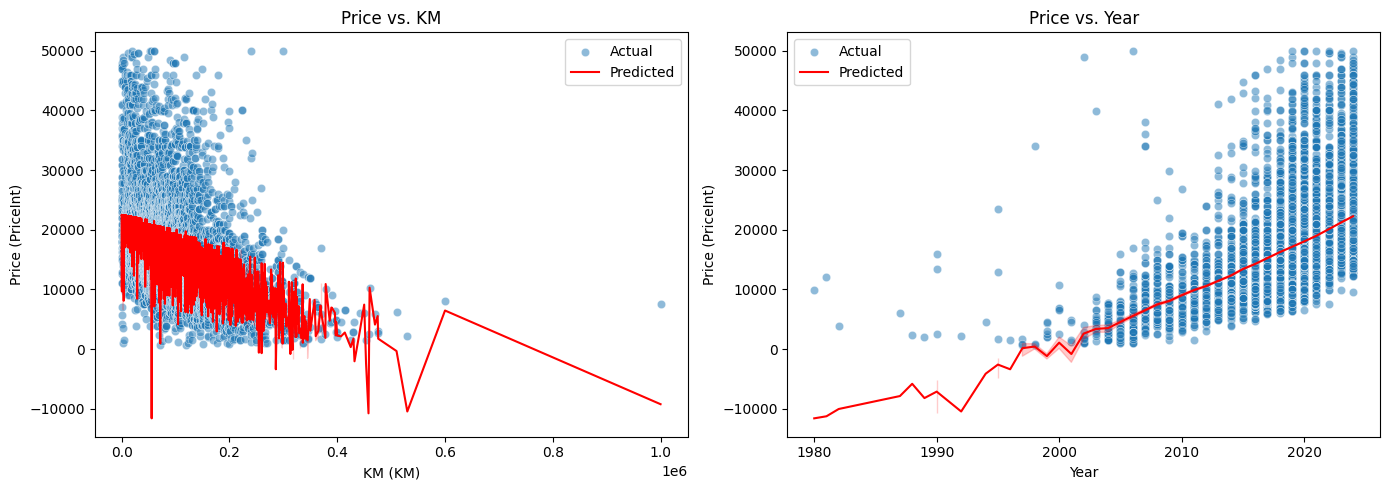

In [273]:
# Create scatter plots with regression lines
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(x=df['KM'], y=df['PriceInt'], alpha=0.5, label='Actual', ax=axes[0])
sns.lineplot(x=df['KM'], y=df['Predicted_Price'], color='red', label='Predicted', ax=axes[0])
axes[0].set_title('Price vs. KM')
axes[0].set_xlabel('KM (KM)')
axes[0].set_ylabel('Price (PriceInt)')

sns.scatterplot(x=df['YEAR'], y=df['PriceInt'], alpha=0.5, label='Actual', ax=axes[1])
sns.lineplot(x=df['YEAR'], y=df['Predicted_Price'], color='red', label='Predicted', ax=axes[1])
axes[1].set_title('Price vs. Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Price (PriceInt)')

plt.tight_layout()
plt.show()  # ✅ Ensures the first plot is displayed before moving to the next


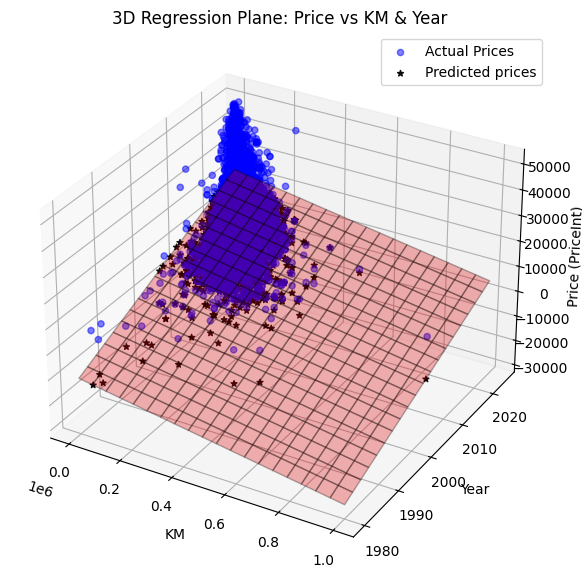

In [274]:
# Create a grid for the regression plane
km_range = np.linspace(df["KM"].min(), df["KM"].max(), 20)
year_range = np.linspace(df["YEAR"].min(), df["YEAR"].max(), 20)
KM_grid, Year_grid = np.meshgrid(km_range, year_range)

# Compute predicted prices for the grid using the linear regression model
Z = model.intercept_ + model.coef_[0] * KM_grid + model.coef_[1] * Year_grid

# Create 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of actual data points
ax.scatter(df["KM"], df["YEAR"], df["PriceInt"], c='blue', marker='o', alpha=0.5, label="Actual Prices")
ax.scatter(df["KM"], df["YEAR"], df["Predicted_Price"], c='black', marker='*', alpha=0.9, label="Predicted prices")


# Plot the regression plane
ax.plot_surface(KM_grid, Year_grid, Z, color='red', alpha=0.3, edgecolor='k')

# Labels and title
ax.set_xlabel('KM')
ax.set_ylabel('Year')
ax.set_zlabel('Price (PriceInt)')
ax.set_title('3D Regression Plane: Price vs KM & Year')

# Show the plot
plt.legend()
plt.show()


In [275]:
# Define independent variables and target variable
df['YEAR2'] = df[["YEAR"]] * df[['YEAR']]
X = df[["YEAR2", "YEAR", "KM"]]
y = df["PriceInt"]

# Train the regression model
modelSquared = LinearRegression()
modelSquared.fit(X, y)

print(modelSquared.coef_)

[ 2.57013878e+01 -1.02736010e+05 -1.13803720e-02]


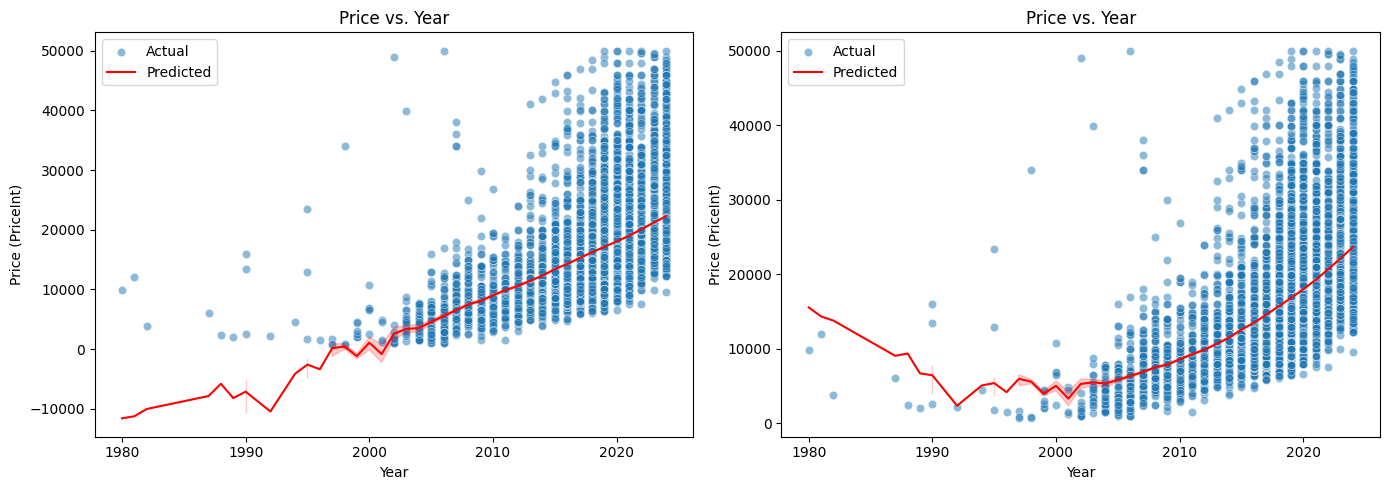

In [276]:
df['Predicted_Price_squared'] = modelSquared.predict(X)

# Create scatter plots with regression lines
fig, axes = plt.subplots(1, 2, figsize=(14, 5))


sns.scatterplot(x=df['YEAR'], y=df['PriceInt'], alpha=0.5, label='Actual', ax=axes[1])
sns.lineplot(x=df['YEAR'], y=df['Predicted_Price_squared'], color='red', label='Predicted', ax=axes[1])
axes[0].set_title('Price vs. Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Price (PriceInt)')

sns.scatterplot(x=df['YEAR'], y=df['PriceInt'], alpha=0.5, label='Actual', ax=axes[0])
sns.lineplot(x=df['YEAR'], y=df['Predicted_Price'], color='red', label='Predicted', ax=axes[0])
axes[1].set_title('Price vs. Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Price (PriceInt)')

plt.tight_layout()
plt.show()  # ✅ Ensures the first plot is displayed before moving to the next


[-1034.36327056  -787.44744022]


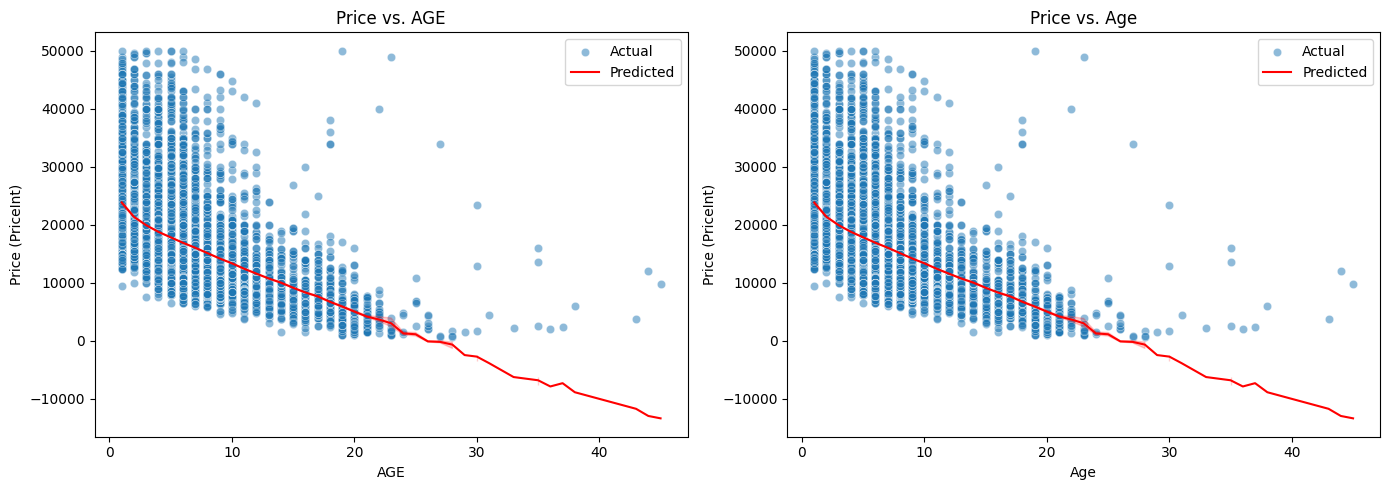

In [277]:
# Define independent variables and target variable
df['LogKM'] = np.log1p(df['KM'])  # Apply log transformation to KM
df['AGE'] = 2025 - df['YEAR']  # Assuming current year is 2025


X = df[["LogKM", "AGE"]]
y = df["PriceInt"]

# Train the regression model
modelLog = LinearRegression()
modelLog.fit(X, y)

print(modelLog.coef_)

df['Predicted_Price_log'] = modelLog.predict(X)

# Create scatter plots with regression lines
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(x=df['AGE'], y=df['PriceInt'], alpha=0.5, label='Actual', ax=axes[1])
sns.lineplot(x=df['AGE'], y=df['Predicted_Price_log'], color='red', label='Predicted', ax=axes[1])
axes[0].set_title('Price vs. AGE')
axes[0].set_xlabel('AGE')
axes[0].set_ylabel('Price (PriceInt)')

sns.scatterplot(x=df['AGE'], y=df['PriceInt'], alpha=0.5, label='Actual', ax=axes[0])
sns.lineplot(x=df['AGE'], y=df['Predicted_Price_log'], color='red', label='Predicted', ax=axes[0])
axes[1].set_title('Price vs. Age')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Price (PriceInt)')

plt.tight_layout()
plt.show()


In [278]:
np.transpose([df.groupby("AGE")["PriceInt"].mean(), 
df.groupby("AGE")["PriceInt"].mean().diff()])

array([[ 25211.92341357,             nan],
       [ 22440.7192029 ,  -2771.20421067],
       [ 19576.42712843,  -2864.29207447],
       [ 18598.03909465,   -978.38803378],
       [ 18381.82934132,   -216.20975333],
       [ 16600.58240119,  -1781.24694012],
       [ 15163.985     ,  -1436.59740119],
       [ 14748.88539326,   -415.09960674],
       [ 14339.39304813,   -409.49234513],
       [ 12537.37719298,  -1802.01585515],
       [ 11848.65427509,   -688.72291789],
       [ 11452.28169014,   -396.37258495],
       [  9918.85350318,  -1533.42818696],
       [  8602.875     ,  -1315.97850318],
       [  8487.7295082 ,   -115.1454918 ],
       [  7862.13821138,   -625.59129681],
       [  7793.73846154,    -68.39974984],
       [  7626.31538462,   -167.42307692],
       [  6121.89655172,  -1504.41883289],
       [  4958.76119403,  -1163.13535769],
       [  4150.48979592,   -808.27139811],
       [  6132.68181818,   1982.19202226],
       [  6166.27272727,     33.59090909],
       [  3